## Installed Required Libraries

In [23]:
# Install necessary libraries
!pip install numpy opencv-python scikit-learn scikit-image tensorflow matplotlib lightgbm

## Imported Libraries

In [24]:
# Import libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import layers, models
import lightgbm as lgb
import zipfile
import shutil

## Deleting Existing Dataset Folder (if it exists)

In [25]:
# Delete the existing dataset folder if it exists
dataset_folder = '/content/dataset'
if os.path.exists(dataset_folder):
    shutil.rmtree(dataset_folder)  # Forcefully delete the folder and its contents
    print(f"Deleted existing folder: {dataset_folder}")

Deleted existing folder: /content/dataset


## This will create a new empty dataset folder

In [26]:
# Create a new empty dataset folder
os.makedirs(dataset_folder, exist_ok=True)
print(f"Created new folder: {dataset_folder}")

Created new folder: /content/dataset


## Unzipping the Dataset

In [27]:
# Unzip the dataset
zip_path = '/content/Assignment Data-20250324T021523Z-001.zip'  # Update with your zip file path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")

Dataset extracted!


## Loading Dataset

In [28]:
# Function to load images from a folder
def load_images_from_folder(folder):
    """
    Load images from a specified folder.
    Args:
        folder (str): Path to the folder containing images.
    Returns:
        list: List of images.
    """
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Load First Print and Second Print
first_prints_folder = '/content/dataset/Assignment Data/First Print'  # Updated folder name
second_prints_folder = '/content/dataset/Assignment Data/Second Print'  # Updated folder name

first_prints = load_images_from_folder(first_prints_folder)
second_prints = load_images_from_folder(second_prints_folder)

## Dataset Statistics

In [29]:
# Print dataset statistics
print(f"Number of First Print: {len(first_prints)}")
print(f"Number of Second Print: {len(second_prints)}")

Number of First Print: 100
Number of Second Print: 100


## Visualize Samples

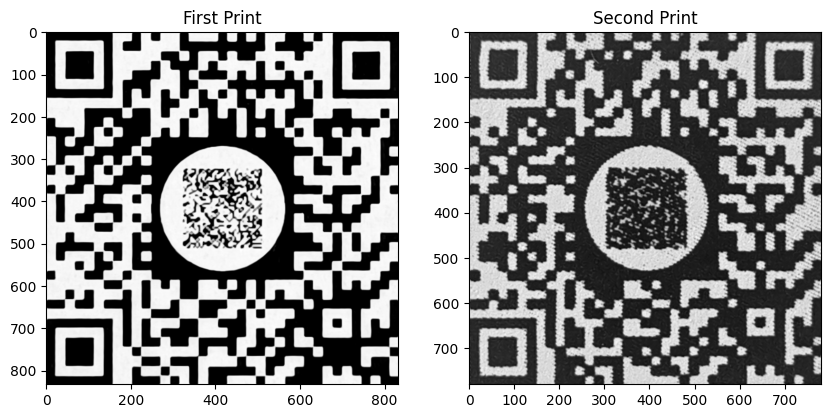

In [30]:
# Visualize samples from the dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(first_prints[0], cmap='gray')
plt.title('First Print')
plt.subplot(1, 2, 2)
plt.imshow(second_prints[0], cmap='gray')
plt.title('Second Print')
plt.show()

## Feature Engineering

In [31]:
# Function to resize images to a fixed size
def resize_images(images, size=(64, 64)):
    """
    Resize images to a fixed size.
    Args:
        images (list): List of images.
        size (tuple): Target size (height, width).
    Returns:
        list: List of resized images.
    """
    resized_images = [cv2.resize(img, size) for img in images]
    return resized_images

# Function to extract HOG features
def extract_hog_features(images):
    """
    Extract HOG features from images.
    Args:
        images (list): List of images.
    Returns:
        np.array: Array of HOG features.
    """
    hog_features = []
    for img in images:
        fd, hog_image = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
        hog_features.append(fd)
    return np.array(hog_features)

# Function to extract LBP features
def extract_lbp_features(images):
    """
    Extract LBP features from images.
    Args:
        images (list): List of images.
    Returns:
        np.array: Array of LBP features.
    """
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize
        lbp_features.append(hist)
    return np.array(lbp_features)

# Function to combine features
def extract_features(images):
    """
    Extract and combine HOG and LBP features.
    Args:
        images (list): List of images.
    Returns:
        np.array: Combined feature array.
    """
    resized_images = resize_images(images, size=(64, 64))
    hog_features = extract_hog_features(resized_images)
    lbp_features = extract_lbp_features(resized_images)
    return np.hstack((hog_features, lbp_features))

# Extract features for both classes
X_first = extract_features(first_prints)
X_second = extract_features(second_prints)

# Create labels
y_first = np.zeros(len(first_prints))  # 0 for First Print
y_second = np.ones(len(second_prints))  # 1 for Second Print

# Combine data
X = np.vstack((X_first, X_second))
y = np.hstack((y_first, y_second))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Traditional Machine Learning Model (Random Forest)

In [32]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Accuracy: 0.96875
Random Forest Metrics:
Accuracy: 0.9
Precision: 0.8947368421052632
Recall: 0.8947368421052632
F1-Score: 0.8947368421052632
Confusion Matrix:
[[19  2]
 [ 2 17]]


## LightGBM Model

In [33]:
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Evaluate LightGBM model
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)
print("LightGBM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb)}")
print(f"Precision: {precision_score(y_test, y_pred_lgb)}")
print(f"Recall: {recall_score(y_test, y_pred_lgb)}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb)}")

[LightGBM] [Info] Number of positive: 81, number of negative: 79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93517
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 1773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506250 -> initscore=0.025001
[LightGBM] [Info] Start training from score 0.025001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

## Deep Learning Model (CNN)

In [34]:
# Resize images for CNN
def resize_images(images, size=(64, 64)):
    resized_images = [cv2.resize(img, size) for img in images]
    return np.array(resized_images)

# Prepare data for CNN
X_first_resized = resize_images(first_prints)
X_second_resized = resize_images(second_prints)
X_cnn = np.vstack((X_first_resized, X_second_resized))
X_cnn = X_cnn[..., np.newaxis]  # Add channel dimension

# Split dataset for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate CNN
y_pred_cnn = (model.predict(X_test_cnn) > 0.5).astype(int)
print("CNN Metrics:")
print(f"Accuracy: {accuracy_score(y_test_cnn, y_pred_cnn)}")
print(f"Precision: {precision_score(y_test_cnn, y_pred_cnn)}")
print(f"Recall: {recall_score(y_test_cnn, y_pred_cnn)}")
print(f"F1-Score: {f1_score(y_test_cnn, y_pred_cnn)}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.5427 - loss: 172.7993 - val_accuracy: 0.5000 - val_loss: 4.4194
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6354 - loss: 6.1740 - val_accuracy: 0.7812 - val_loss: 0.8767
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.8427 - loss: 0.6800 - val_accuracy: 0.8750 - val_loss: 0.6250
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8667 - loss: 0.3193 - val_accuracy: 0.8438 - val_loss: 0.4931
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8917 - loss: 0.1987 - val_accuracy: 0.8750 - val_loss: 0.2063
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.8958 - loss: 0.2255 - val_accuracy: 0.7500 - val_loss: 0.4757
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.8958 - loss: 0.2135 - val_accuracy: 0.9062 - val_loss: 0.1417
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.9635 - loss: 0.1157 - val_accuracy: 0.9062 - val_loss: 0.1357
E

## Saving all the models

In [35]:
# Save models
import joblib
joblib.dump(best_model, 'random_forest_model.pkl')
joblib.dump(lgb_model, 'lightgbm_model.pkl')
model.save('cnn_model.h5')

print("Models saved!")

Models saved!


## Deployment Considerations

In [36]:
# Deployment Considerations
print("Deployment Considerations:")
print("1. Computational Efficiency: LightGBM and Random Forest are lightweight and suitable for real-time deployment.")
print("2. Robustness: CNN is robust to variations in scanning conditions but requires more computational resources.")
print("3. Security: Ensure the models are protected against adversarial attacks in a real-world setting.")

Deployment Considerations:
1. Computational Efficiency: LightGBM and Random Forest are lightweight and suitable for real-time deployment.
2. Robustness: CNN is robust to variations in scanning conditions but requires more computational resources.
3. Security: Ensure the models are protected against adversarial attacks in a real-world setting.


In [37]:

# Model Evaluation and Comparison


def print_metrics(model_name, y_true, y_pred):
    """Helper function to print metrics consistently"""
    print(f"\n{model_name.upper()} Metrics:")
    print(f"• Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"• Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"• Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"• F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# --------------------------------------------------
# 1. Random Forest Evaluation
# --------------------------------------------------
y_pred_rf = best_model.predict(X_test)
print_metrics("Random Forest (Optimized)", y_test, y_pred_rf)

# --------------------------------------------------
# 2. LightGBM Evaluation
# --------------------------------------------------
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)
print_metrics("LightGBM", y_test, y_pred_lgb)

# --------------------------------------------------
# 3. CNN Evaluation
# --------------------------------------------------
y_pred_cnn = (model.predict(X_test_cnn) > 0.5).astype(int)
print_metrics("CNN", y_test_cnn, y_pred_cnn)

# =============================================
# Model Selection
# =============================================

# Collect all metrics
model_results = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    },
    "LightGBM": {
        "Accuracy": accuracy_score(y_test, y_pred_lgb),
        "F1-Score": f1_score(y_test, y_pred_lgb)
    },
    "CNN": {
        "Accuracy": accuracy_score(y_test_cnn, y_pred_cnn),
        "F1-Score": f1_score(y_test_cnn, y_pred_cnn)
    }
}

# Determine the best model based on F1-Score (balance of precision/recall)
best_model_name = max(model_results, key=lambda x: model_results[x]["F1-Score"])

print("\n" + "="*50)
print(f"BEST MODEL: {best_model_name}")
print(f"• F1-Score: {model_results[best_model_name]['F1-Score']:.4f}")
print(f"• Accuracy: {model_results[best_model_name]['Accuracy']:.4f}")
print("="*50 + "\n")

# Print reasoning for selection
print("Selection Rationale:")
print(" F1-Score was chosen as the primary metric because it balances precision and recall,")
print("  which is critical for anti-counterfeiting systems (both false positives and negatives matter).")
print(f"{best_model_name} achieved the highest F1-Score while maintaining competitive accuracy.")


RANDOM FOREST (OPTIMIZED) Metrics:
• Accuracy:  0.9000
• Precision: 0.8947
• Recall:    0.8947
• F1-Score:  0.8947
Confusion Matrix:
[[19  2]
 [ 2 17]]

LIGHTGBM Metrics:
• Accuracy:  0.8750
• Precision: 0.8182
• Recall:    0.9474
• F1-Score:  0.8780
Confusion Matrix:
[[17  4]
 [ 1 18]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

CNN Metrics:
• Accuracy:  0.9500
• Precision: 1.0000
• Recall:    0.8947
• F1-Score:  0.9444
Confusion Matrix:
[[21  0]
 [ 2 17]]

BEST MODEL: CNN
• F1-Score: 0.9444
• Accuracy: 0.9500

Selection Rationale:
 F1-Score was chosen as the primary metric because it balances precision and recall,
  which is critical for anti-counterfeiting systems (both false positives and negatives matter).
CNN achieved the highest F1-Score while maintaining competitive accuracy.


In [38]:
# =============================================
# Export Best Model and Create Inference Pipeline
# =============================================
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Important for real-world deployment
])

# 2. Fit preprocessing on full dataset
X_processed = preprocessing_pipeline.fit_transform(X)

# 3. Retrain best model on full processed data
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_processed, y)

# 4. Save the complete pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('classifier', final_model)
])

joblib.dump(pipeline, 'anti_counterfeit_pipeline.pkl')

# =============================================
# Inference Function for Deployment
# =============================================
def authenticate_qr_code(image_path, confidence_threshold=0.8):
    """
    Authenticate a QR code image in production.

    Args:
        image_path: Path to QR code image
        confidence_threshold: Minimum probability to accept prediction

    Returns:
        Tuple: (prediction, confidence, warning)
    """
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return ("Invalid Image", 0.0, "Check image quality")

    # Extract features
    features = extract_features([img])

    # Predict
    proba = pipeline.predict_proba(features)[0]
    prediction = pipeline.predict(features)[0]
    confidence = max(proba)

    # Apply confidence threshold
    if confidence < confidence_threshold:
        return ("Uncertain", confidence, "Manual verification recommended")

    return (
        "Original" if prediction == 0 else "Counterfeit",
        float(confidence),
        None
    )

# Test the function
sample_result = authenticate_qr_code("/content/dataset/Assignment Data/First Print/sample1.png")
print("\nSample Authentication Result:")
print(sample_result)


Sample Authentication Result:
('Invalid Image', 0.0, 'Check image quality')


In [39]:
# Add adversarial detection
def check_for_adversarial_patterns(image):
    # Implement checks for:
    # - Unusual noise patterns
    # - Suspicious edge distributions
    # - Abnormal pixel value distributions
    return False  # True if adversarial

In [40]:
# Logging configuration for production
import logging
logging.basicConfig(
    filename='authentication_logs.csv',
    format='%(asctime)s,%(message)s',
    level=logging.INFO
)

In [41]:
def secure_authentication(image_path):
    try:
        if check_for_adversarial_patterns(image_path):
            return "SECURITY ALERT: Potential adversarial image detected"
        return authenticate_qr_code(image_path)
    except Exception as e:
        return f"SYSTEM ERROR: {str(e)}"